<p><h1><center>Prediction of Medical Costs</center></h1></p>
<p><h2><center>Ensemble Modeling</center></h2></p>
<center>Data mining techniques used: Random forest, Ridge Regression, Support vector regression with a radial kernel,Linear regression.</center>



<h2><a href="https://github.com/mpavlenk/Ensemble-Prediction-of-Medical-Costs">Data file</a><h2>
<h3><strong>INDEX:</strong><br></h3>
<p>1: <a href="#Data-processing">Data processing</a><br>
2: <a href="#Descriptive-statistics">Descriptive statistics</a><br>
3: <a href="#Visualizations">Visualizations</a><br>
4: <a href="#Model generation">Model generation</a><br>
5: <a href="#Ensemble prediction with Stacking">Ensemble prediction with Stacking</a><br>                   
6: <a href="#Conclusion">Conclusion</a>

Importing libraries

In [33]:
library(e1071)
library(tibble)
library(psych)
library(dplyr)
library(caret)
library(caretEnsemble)
library(GGally)
library(ggplot2)
library(monomvn)
library(randomForest)
library(kernlab)
library(elasticnet)
library(car)
library(corrplot)

Overview of data

In [2]:
data <- read.csv("insurance.csv")
glimpse(data)
#There are 1338 observations and 7 variables in the dataset. 3 categorical variables.

Observations: 1,338
Variables: 7
$ age      <int> 19, 18, 28, 33, 32, 31, 46, 37, 37, 60, 25, 62, 23, 56, 27...
$ sex      <fct> female, male, male, male, male, female, female, female, ma...
$ bmi      <dbl> 27.900, 33.770, 33.000, 22.705, 28.880, 25.740, 33.440, 27...
$ children <int> 0, 1, 3, 0, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0...
$ smoker   <fct> yes, no, no, no, no, no, no, no, no, no, no, yes, no, no, ...
$ region   <fct> southwest, southeast, southeast, northwest, northwest, sou...
$ charges  <dbl> 16884.924, 1725.552, 4449.462, 21984.471, 3866.855, 3756.6...


<h1><font color="red"><center id="Data-processing">Data processing<a class="anchor-link" href="#Data-processing">&#182;</a><center></font></h1>

In [3]:
colSums(is.na(data))
#No missing values observed

age      sex      bmi children   smoker   region  charges 
       0        0        0        0        0        0        0

In [4]:
#Converting variables into dummy variables
data$male=ifelse(data$sex=="male",1,0)
data$sex=NULL
data$smoker=ifelse(data$smoker=="yes",1,0)
head(data)

age,bmi,children,smoker,region,charges,male
19,27.900,0,1,southwest,16884.924,0
18,33.770,1,0,southeast,1725.552,1
28,33.000,3,0,southeast,4449.462,1
33,22.705,0,0,northwest,21984.471,1
32,28.880,0,0,northwest,3866.855,1
31,25.740,0,0,southeast,3756.622,0


<h1><font color="red"><center id=Descriptive-statistics">Descriptive statistics<a class="anchor-link" href="#"Descriptive-statistics">&#182;</a><center></font></h1>

In [5]:
describe(data)
#The distribution of charges is right skewed. 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
age,1,1338,3.920703e+01,1.404996e+01,39.000,3.900560e+01,17.791200,18.000,64.00,46.00,0.05554775,-1.24754314,0.38410242
bmi,2,1338,3.066340e+01,6.098187e+00,30.400,3.050021e+01,6.197268,15.960,53.13,37.17,0.28341055,-0.05942352,0.16671423
children,3,1338,1.094918e+00,1.205493e+00,1.000,9.375000e-01,1.482600,0.000,5.00,5.00,0.93627750,0.19244011,0.03295616
smoker,4,1338,2.047833e-01,4.036940e-01,0.000,1.315299e-01,0.000000,0.000,1.00,1.00,1.46148357,0.13603757,0.01103632
region*,5,1338,2.515695e+00,1.104885e+00,3.000,2.519590e+00,1.482600,1.000,4.00,3.00,-0.03801512,-1.32972605,0.03020571
charges,6,1338,1.327042e+04,1.211001e+04,9382.033,1.107602e+04,7440.809314,1121.874,63770.43,62648.55,1.51248252,1.58895424,331.06745432
male,7,1338,5.052317e-01,5.001596e-01,1.000,5.065299e-01,0.000000,0.000,1.00,1.00,-0.02090444,-2.00105689,0.01367353


<h1><font color="red"><center id="Visualizations">Visualizations<a class="anchor-link" href="#Visualizations">&#182;</a><center></font></h1>

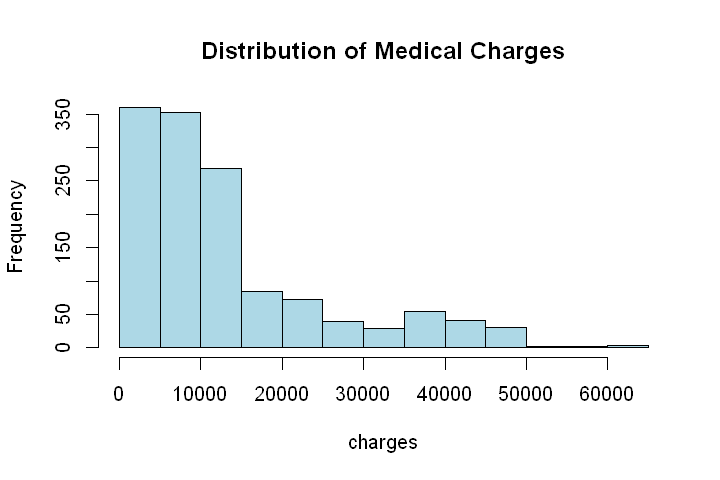

In [6]:
#Distribution of dependent variable "charges". Charges $0-$15000 have the highest count
options(repr.plot.width=6, repr.plot.height=4)
hist(data$charges, col = 'lightblue', xlab="charges",main = 'Distribution of Medical Charges')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


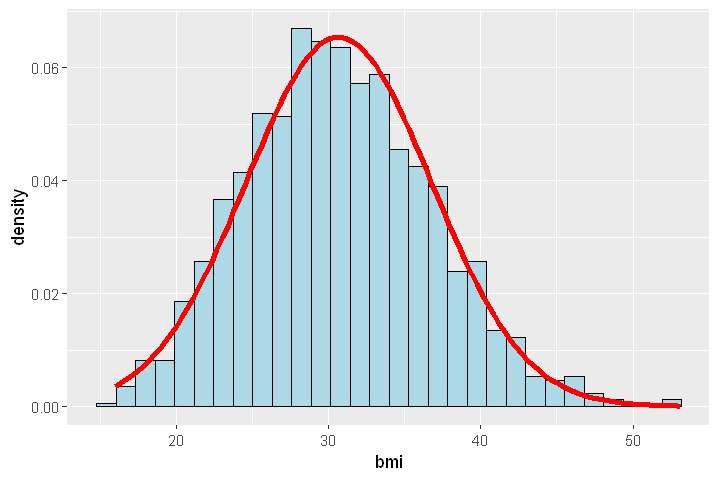

In [7]:
#BMI follows a normal distribution with the mean value around 31.
ggplot(data,aes(bmi))+
  geom_histogram(aes(y=..density..),col="black",fill="lightblue")+
  stat_function(fun=dnorm,color="red",args = list(mean=mean(data$bmi),sd=sd(data$bmi)),lwd=1.5)

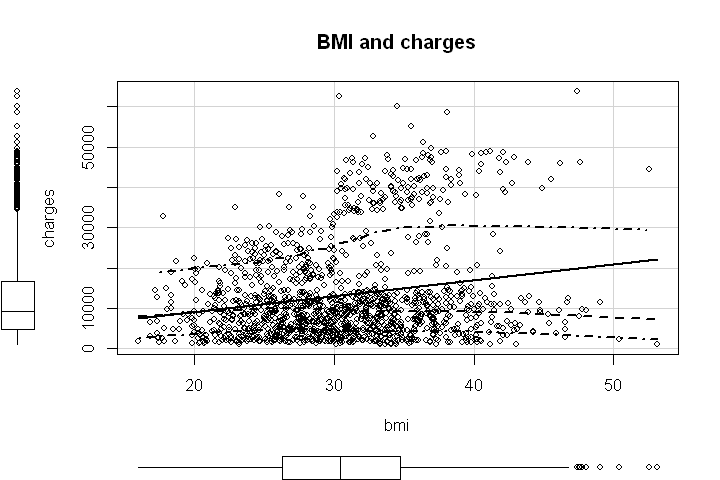

In [8]:
#BMI and charges have positive linear relationships, however it is not a strong correlation
scatterplot(data$bmi,data$charges, xlab="bmi", ylab="charges",regLine=TRUE,col=carPalette(),main="BMI and charges")

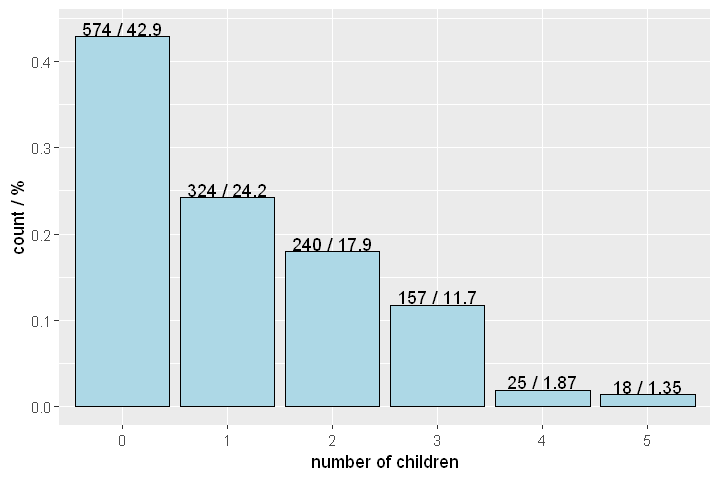

In [9]:
#Children
#This graph shows proportion of children across all population in the sample. The distribution is skewed to the right. 
# Almost half of the people have no chilred and the count decreases as number of children increases.
data.frame(prop.table(table(data$children)))%>%
  ggplot(aes(Var1,Freq))+
  geom_bar(stat="identity",fill="lightblue",col="black")+
  geom_text(aes(y=Freq+.01,label=paste0(Freq*nrow(data)," / ",signif(Freq,3)*100)))+
  labs(x="number of children",y="count / %")

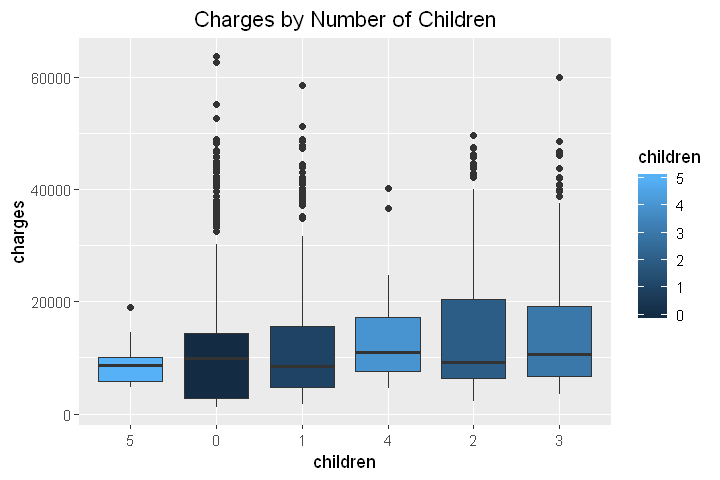

In [10]:
ggplot(data, aes(reorder(children, charges), charges, fill = children))+
  geom_boxplot()+
  labs(    title = "Charges by Number of Children",
           x = "children")+
  theme(plot.title = element_text(hjust = .5))

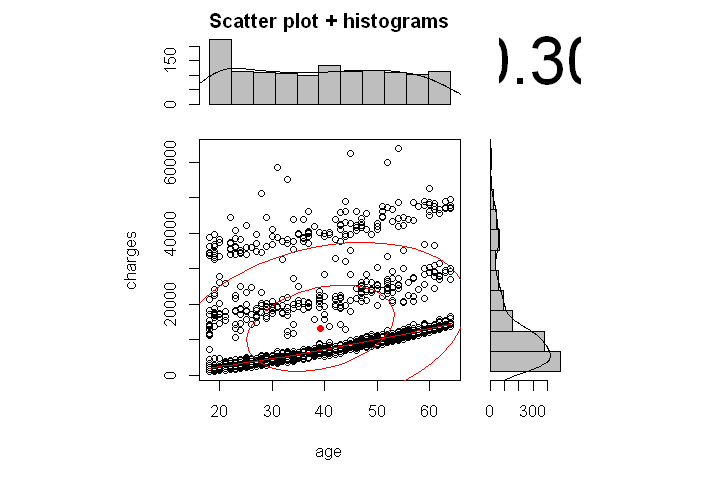

In [11]:
#Age
#The scatterplot depicts that the age follows uniform distribution, whereas charges are right skewed. 
#We also observe positive linear relationships between these two variables. The older a person, the higher the charges are.
scatter.hist(data$age,data$charges, xlab="age",ylab="charges")

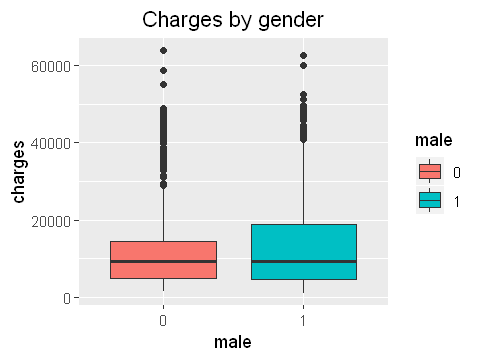

In [36]:
#Male
#There is no significant difference in median values of charges for males and females. However, charges for males demonstrate
#higher variability then for women.
ggplot(data, aes(as.factor(male), charges, fill = as.factor(male)))+
  geom_boxplot()+
  labs(title = "Charges by gender",
       x = "male")+
  scale_fill_discrete("male")+
  theme(plot.title = element_text(hjust = .5))

[1] "578"  "282"  "331"  "289"  "884"  "669"  "1097" "186"  "743"  "382" 
[11] "1231" "820"  "56"   "1302" "1123" "678"  "570"  "588"  "257"  "87"  
[21] "544"  "1301" "1242" "1063" "489"  "531"  "902"  "952"  "1241" "110" 
[31] "1147" "35"   "176"  "40"   "329"  "1285" "252"  "95"   "861"  "740"

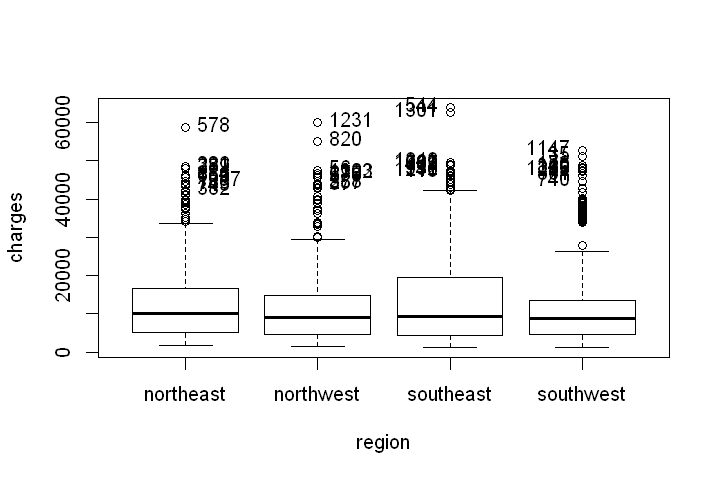

In [13]:
#Region
#We observe outliers as well as difference in median values of charges per region.
#The highest charges are noticed in the northeast.
scatterplot(data$region,data$charges,xlab="region",ylab="charges")

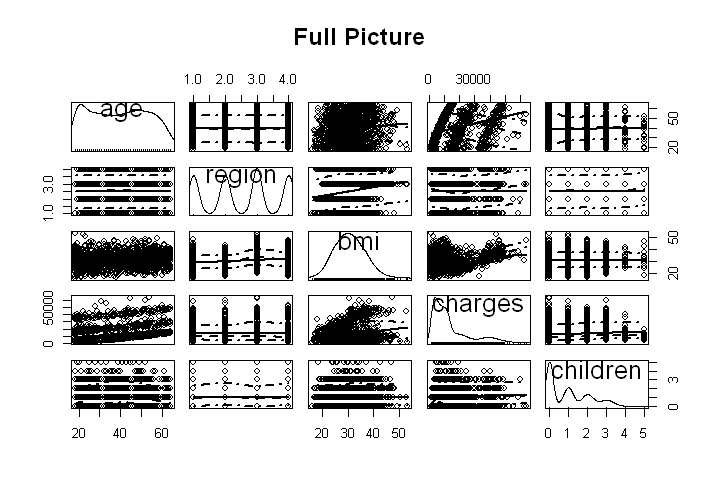

In [14]:
#From scatterplotMatrix we can see distribution of each variable (uniform, normal, right skewed), 
#linear relationships of age&bmi with charges; highest bmi is recorded in the southeast;
#inverse relationships of children and charges.
suppressWarnings(scatterplotMatrix(~ age+ region+bmi+charges+children, data=data, col="black", regline=TRUE, main="Full Picture"))

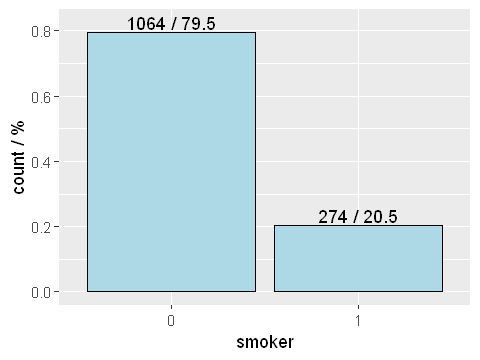

In [34]:
#Smoker
#The graph depicts almost 80% of smokers and 20% non-smokers. Let's see how it is in relationships with charges. 
options(repr.plot.width=4, repr.plot.height=3)
data.frame(prop.table(table(data$smoker)))%>%
  ggplot(aes(Var1,Freq))+
  geom_bar(stat="identity",fill="lightblue",col="black")+
  geom_text(aes(y=Freq+.03,label=paste0(Freq*nrow(data)," / ",signif(Freq,3)*100)))+
  labs(x="smoker",y="count / %")

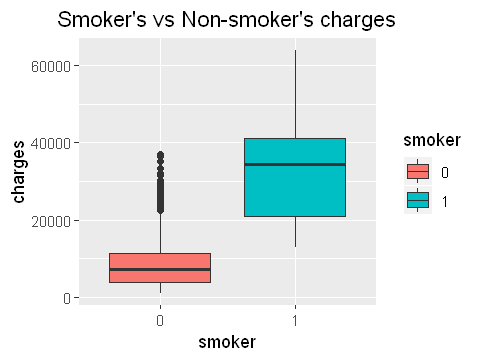

In [35]:
#We observe a significant contrast in charges for smokers vs non-smokers. Obviously, smokers are charged more.
ggplot(data, aes(as.factor(smoker), charges, fill = as.factor(smoker)))+
  geom_boxplot()+
  labs(title = "Smoker's vs Non-smoker's charges",
       x = "smoker")+
  scale_fill_discrete("smoker")+
  theme(plot.title = element_text(hjust = .5))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


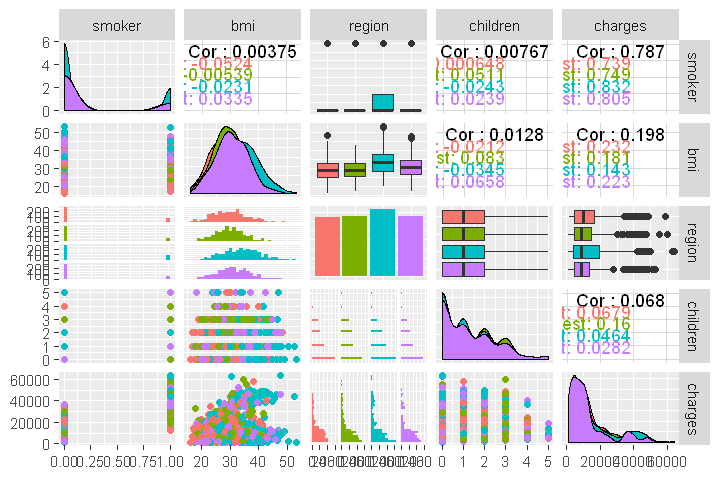

In [17]:
#From the following illustration, we can additionally confirm the following: 
# 1. there are more obese people among non-smokers than smokers
# 2. more obese people are observed in southeast.
# 3. obese people are charged more than non-obese.
# 4. the charges are higher in northeast than in other regions.
ggpairs(data, columns = c("smoker", "bmi","region", "children", "charges"), ggplot2::aes(colour=region))


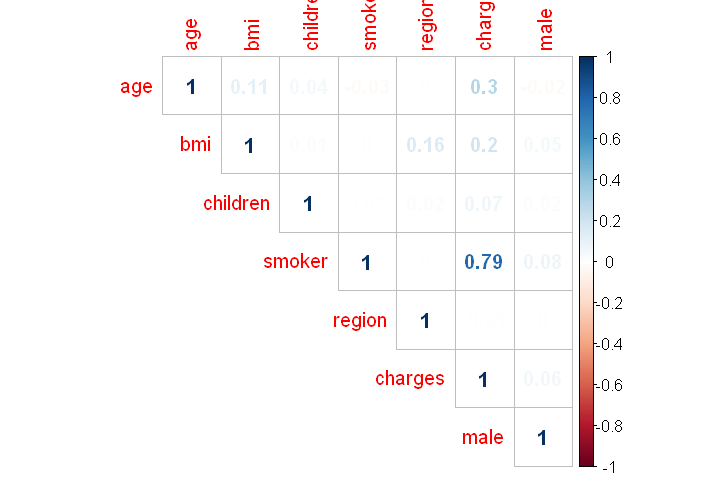

In [18]:
# Correlation analysis
#One correlation stands out in this graph - a strong positive correlation between charges and smoker. 
# Other variables are not as strongly correlated, the second largest one is age and charges (0.3), which is followed by the correlation
# of bmi and charges 0.2. 
newdata<-data
for(i in which(sapply(newdata,is.factor))){
  newdata[,i]<-as.numeric(newdata[,i])
}
corrplot::corrplot(cor(newdata),method = "number",type = "upper")

<h1><font color="red"><center id="Model generation">Model generation<a class="anchor-link" href="#Model generation">&#182;</a><center></font></h1>

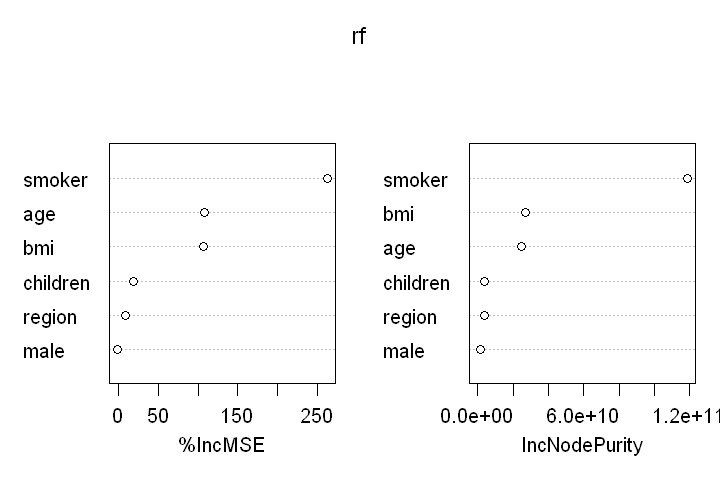

In [19]:
#We use randon forest to see which variables are more significant for the dataset.
#Based on the visualization, smoker, age and bmi are more significant. While choldren, 
#region and gender are evidently less significant, which means they do not have a strong effect on the charges.
set.seed(123)
rf<-randomForest(charges~smoker+age+bmi+children+region+male,data,importance = T,ntree = 1000)
varImpPlot(rf)

In [20]:
#We will use linear regression to compare the results with the random forest output.
#Smoker, Regions, BMI, age, children are significant variables due to low p-values (<0.5)
children<-as.character(data$children)
model <-lm(charges ~ smoker+region+bmi+age+male+children+smoker, data)
summary(model)


Call:
lm(formula = charges ~ smoker + region + bmi + age + male + children + 
    smoker, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11938.5      987.8 -12.086  < 2e-16 ***
smoker           23848.5      413.1  57.723  < 2e-16 ***
regionnorthwest   -353.0      476.3  -0.741 0.458769    
regionsoutheast  -1035.0      478.7  -2.162 0.030782 *  
regionsouthwest   -960.0      477.9  -2.009 0.044765 *  
bmi                339.2       28.6  11.860  < 2e-16 ***
age                256.9       11.9  21.587  < 2e-16 ***
male              -131.3      332.9  -0.394 0.693348    
children           475.5      137.8   3.451 0.000577 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.8 on 8 

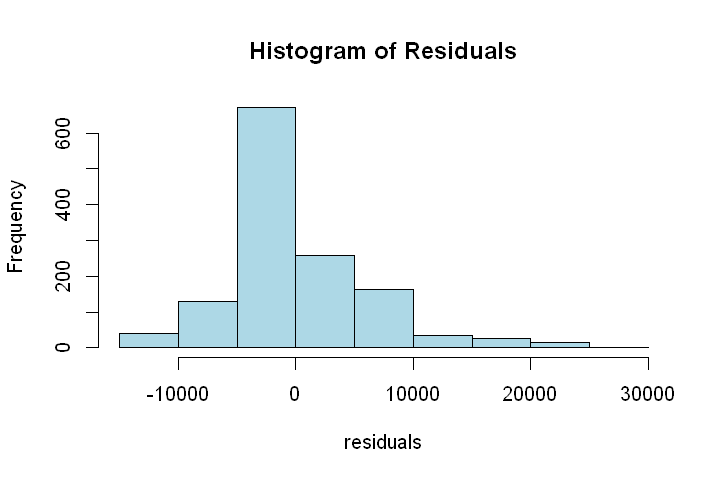

In [21]:
#Residuals follow normal distribution with a slight skewness to the right
par(mfrow=c(1,1))
hist(model$residuals, col = 'lightblue', xlab="residuals",main = 'Histogram of Residuals')

<h1><font color="red"><center id="Ensemble prediction with Stacking">Ensemble prediction with Stacking<a class="anchor-link" href="#Ensemble prediction with Stacking">&#182;</a><center></font></h1>

In [22]:
#To achieve a higher accuracy in prediction, we will combine different model predictions into one ensemble prediction.
#We will use stacking method for it.
#Now we split the data into train and test datasets
train <- createDataPartition(y = data$charges,p = 0.75,list = FALSE)
training <- data[train,]
testing <- data[-train,]

In [23]:
#Next we create a repeated cross validation object 
fit <- trainControl(method = 'repeatedcv',number = 10, repeats = 5, summaryFunction=defaultSummary)

In [24]:
#We need to build an object to hold the list of algorithms
algorithmList <- c('lm','pls','rf', 'svmRadial')

In [25]:
#Training of sub models
models <- suppressWarnings(caretList(charges~., data=training, trControl=fit, methodList=algorithmList, preProcess = c("center","scale")))

In [26]:
results <- resamples(models)
summary(results)


Call:
summary.resamples(object = results)

Models: lm, pls, rf, svmRadial 
Number of resamples: 50 

MAE 
              Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
lm        3367.374 3908.792 4072.781 4084.418 4278.343 4557.803    0
pls       3342.578 3889.767 4088.213 4077.447 4277.605 4565.457    0
rf        1892.807 2462.270 2620.427 2601.737 2789.533 3006.858    0
svmRadial 1934.345 2379.315 2657.734 2591.984 2759.417 3075.969    0

RMSE 
              Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
lm        4831.373 5530.407 6028.345 5990.518 6418.054 6950.857    0
pls       4823.589 5513.715 6039.150 5991.279 6430.297 6915.963    0
rf        3053.958 4255.861 4743.759 4634.474 5084.355 5691.051    0
svmRadial 3331.225 4416.491 4891.325 4777.081 5239.100 5697.835    0

Rsquared 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
lm        0.6397341 0.7276422 0.7657089 0.7615363 0.8044512 0.8559276    0
pls       0.6429718 0.7285246 0.766

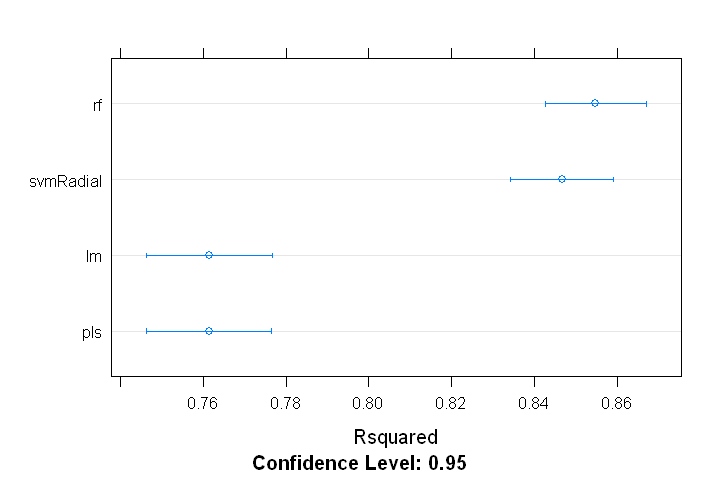

In [27]:
#This demonstrates that SVM is the optimal model out of four, it is followed by random forest.
dotplot(results, metric = 'Rsquared')

In [28]:
#Correlation of predictions
# Some of the models show relatively low correlation between each other, which means that they have different
# predictions. Ensemble prediction is more beneficial with the models suggesting different predictions.
modelCor(results)

,lm,pls,rf,svmRadial
lm,1.0000000,0.9974380,0.6040723,0.6646681
pls,0.9974380,1.0000000,0.6070780,0.6654061
rf,0.6040723,0.6070780,1.0000000,0.8074397
svmRadial,0.6646681,0.6654061,0.8074397,1.0000000


In [29]:
#Combine predictions using GLM
stack.glm <- caretStack(models, method="glm", metric="RMSE", trControl=fit)
print(stack.glm)

A glm ensemble of 2 base models: lm, pls, rf, svmRadial

Ensemble results:
Generalized Linear Model 

5030 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 4527, 4527, 4528, 4526, 4526, 4527, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  4557.751  0.8613796  2485.716



In [30]:
summary(stack.glm)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9593.3  -1829.1   -981.0   -392.8  25951.9  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -107.28330  104.17656  -1.030 0.303143    
lm             1.16177    0.33787   3.438 0.000590 ***
pls           -1.17986    0.33840  -3.487 0.000493 ***
rf             0.61585    0.02710  22.728  < 2e-16 ***
svmRadial      0.41332    0.03146  13.139  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 20836970)

    Null deviance: 7.5822e+11  on 5029  degrees of freedom
Residual deviance: 1.0471e+11  on 5025  degrees of freedom
AIC: 99048

Number of Fisher Scoring iterations: 2


In [31]:
#Checking performance of model on the test dataset
#Rsquared is 89% which indicates there is a room for improvement of the model
prediction <- predict(stack.glm, testing)
act_pred <- data.frame(obs=testing$charges, pred=prediction)
defaultSummary(act_pred)

RMSE     Rsquared          MAE 
4641.8979204    0.8411214 2587.8931121

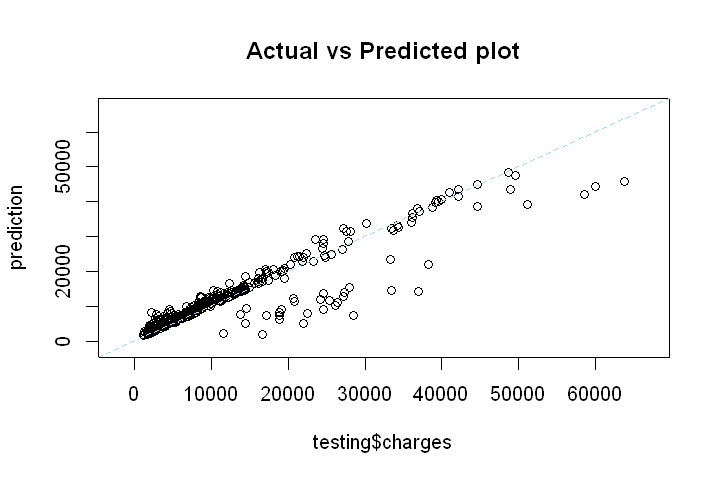

In [32]:
#Plotting Actual vs predicted values
axisRange <- extendrange(c(testing$charges, prediction))
plot(testing$charges, prediction, ylim = axisRange, xlim = axisRange, main = 'Actual vs Predicted plot')
abline(0, 1, col = "lightblue", lty = 2)

<h2><font color="red"><center id="Conclusion">Conclusion<a class="anchor-link" href="#Conclusion">&#182;</a><center></font></h2>

We have analyzied the data and can conclude the following:

1) medical charges are highly dependant on smoking status. if a person smokes, he has much higher charges than 
the one who doesnt.

2) obesity also affects medical charges. Obese people get higher bills than non-obese people. 

3) age influences the charges as well. Older people get to pay more.